In [374]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, RFE
from sklearn.decomposition import PCA
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import (
    StandardScaler, label_binarize, PolynomialFeatures,
    RobustScaler, robust_scale, quantile_transform, QuantileTransformer)
from sklearn.compose import make_column_selector, ColumnTransformer
from scipy.stats.mstats import winsorize
from sklearn.calibration import CalibratedClassifierCV
import xgboost
from joblib import dump, load
np.random.seed(0)  # make sure results are reproducible

In [318]:
%env PATH=/home/jdkent/.conda/envs/comfy_pants/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/opt/conda/bin


env: PATH=/home/jdkent/.conda/envs/comfy_pants/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/opt/conda/bin


In [319]:
TRAINING_DATA_PATH = '../data/BipolarDerivedDataTraining.csv'
TESTING_DATA_PATH = '../data/BipolarDerivedDataTesting.csv'
NTHREADS = 32

In [349]:
training_X = pd.read_csv(TRAINING_DATA_PATH)
training_y = label_binarize(pd.read_csv(TRAINING_DATA_PATH)['group'], classes=["Case", "Control"]).squeeze()
testing_X = pd.read_csv(TESTING_DATA_PATH)

In [350]:
missing_cols = [
    'ses_ladder_rung',
    'history_smoking', 'frequency_currentsmoking',
    'age_at_first_mood_syndrome', 'madrs_score', 'ymrs_score',
    'suicideideation_rating_mostsevere_life',
    'suicideideation_rating_mostsevere_1month',
    'suicideattempts_lifetimenumber'
]
missing_cols.reverse()
for col in missing_cols:
    testing_X.insert(4, col, ["NOT REAL"] * testing_X.shape[0])
testing_X.insert(1, "group", ["NOT REAL"] * testing_X.shape[0])
testing_X.rename(columns={"Age": "age", "Sex": "gender", 'Hand': 'handedness'}, inplace=True)

In [351]:
set(training_X.columns) - set(testing_X.columns)

set()

In [352]:
training_X.columns[:17]

Index(['record_id', 'group', 'age', 'gender', 'handedness', 'ses_ladder_rung',
       'history_smoking', 'frequency_currentsmoking',
       'age_at_first_mood_syndrome', 'madrs_score', 'ymrs_score',
       'suicideideation_rating_mostsevere_life',
       'suicideideation_rating_mostsevere_1month',
       'suicideattempts_lifetimenumber', 'allvol_unknown',
       'allvol_ctx_rh_posterior_insula', 'allvol_ctx_lh_posterior_insula'],
      dtype='object')

In [353]:
testing_X.columns[:17]

Index(['record_id', 'group', 'age', 'gender', 'handedness', 'ses_ladder_rung',
       'history_smoking', 'frequency_currentsmoking',
       'age_at_first_mood_syndrome', 'madrs_score', 'ymrs_score',
       'suicideideation_rating_mostsevere_life',
       'suicideideation_rating_mostsevere_1month',
       'suicideattempts_lifetimenumber', 'allvol_unknown',
       'allvol_ctx_rh_posterior_insula', 'allvol_ctx_lh_posterior_insula'],
      dtype='object')

## Model 1 (XGBoost with feature selection)

In [321]:
# supposedly ideal "scale_pos_weight"
best_spw = (training_y == 0).sum() / training_y.sum()
best_spw

1.8387096774193548

In [322]:
np.random.seed(0) 
MODEL1 = '../models/model1-jdkent.joblib'
OVERWRITE_MODEL1 = False
if not os.path.isfile(MODEL1) or OVERWRITE_MODEL1:
    os.remove(MODEL1)
    select_data = ColumnTransformer(
        [(
            "select_features",
            "passthrough", 
            make_column_selector(pattern="31p.*[^r]$|t1r.*_m|alff.*_m|allvol|dti"))],
        remainder='drop'
    )

    fix_outliers = QuantileTransformer(output_distribution='normal')

    imputer = IterativeImputer(add_indicator=False,
                               initial_strategy='median',
                               imputation_order='random',
                               sample_posterior=True,
                               max_iter=50,
                               n_nearest_features=50,
                               random_state=42)

    scaler = StandardScaler()
    kbest = SelectKBest(k=1000)
    pca = PCA(n_components=40, whiten=True)
    select_pca = SelectKBest(k=5)
    clf = xgboost.XGBClassifier(
        n_estimators=2500, subsample=0.8, learning_rate=0.001,
        max_depth=5, scale_pos_weight=3)


    pipeline1 = Pipeline([("data", select_data),
                          ("outlier", fix_outliers),
                          ("imp", imputer),
                          ("scaler", scaler),
                          ("kbest", kbest),
                          ("pca", pca),
                          ("select", select_pca),
                          ("clf", clf)])
    pipeline1.fit(training_X, training_y)
    # write model to file
    dump(pipeline1, MODEL1)
else:
    pipeline1 = load(MODEL1)

prediction1 = pipeline1.predict(testing_X)
prediction1

/home/jdkent/.conda/envs/comfy_pants/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)


array([0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1])

In [323]:
# intuition on whether the model is split approx 50/50
display((prediction1 == 1).sum())
display((prediction1 == 0).sum())

18

21

## Model 2 (Logistic Regression with feature selection)

In [405]:
np.random.seed(0)
MODEL2 = '../models/model2-jdkent.joblib'
OVERWRITE_MODEL2 = True
if not os.path.isfile(MODEL2) or OVERWRITE_MODEL2:
    os.remove(MODEL2)
    select_data = ColumnTransformer(
        [(
            "select_features",
            "passthrough", 
            make_column_selector(pattern="31p.*[^r]$|t1r.*_m|alff.*_m|allvol|dti"))],
        remainder='drop'
    )

    fix_outliers = QuantileTransformer(output_distribution='normal')

    imputer = IterativeImputer(add_indicator=False,
                               initial_strategy='median',
                               imputation_order='random',
                               sample_posterior=True,
                               max_iter=50,
                               n_nearest_features=50,
                               random_state=42)

    scaler = StandardScaler()
    kbest = SelectKBest(k=1000)
    pca = PCA(n_components=40, whiten=True)
    selector = LogisticRegression(C=1000, class_weight={0: 1, 1: 3}, random_state=42, max_iter=10000)

    rfe = RFE(selector, n_features_to_select=10)

    clf = LogisticRegression(C=1000, class_weight={0: 1, 1: 3}, random_state=42, max_iter=10000)

    pipeline2 = Pipeline([("data", select_data),
                          ("outliers", fix_outliers),
                          ("imp", imputer),
                          ("scaler", scaler),
                          ("kbest", kbest),
                          ("pca", pca),
                          ("rfe", rfe),
                          ("clf", clf)])
    pipeline2.fit(training_X, training_y)
    # write model to file
    dump(pipeline2, MODEL2)
else:
    pipeline2 = load(MODEL2)

prediction2 = pipeline2.predict(testing_X)
prediction2

/home/jdkent/.conda/envs/comfy_pants/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:2357: UserWarning: n_quantiles (1000) is greater than the total number of samples (88). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))


array([0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0])

In [406]:
display((prediction2 == 1).sum())
display((prediction2 == 0).sum())

20

19

## Model 3 (SVM with feature selection)

In [ ]:
MODEL3 = '../models/model3-jdkent.joblib'
OVERWRITE_MODEL3 = True

if not os.path.isfile(MODEL3) or OVERWRITE_MODEL3:
    os.remove(MODEL3)
    select_data = ColumnTransformer(
        [(
            "select_features",
            "passthrough", 
            make_column_selector(pattern="31p.*[^r]$|t1r.*_m|alff.*_m|allvol|dti"))],
        remainder='drop'
    )

    fix_outliers = QuantileTransformer(output_distribution='normal')

    imputer = IterativeImputer(add_indicator=False,
                               initial_strategy='median',
                               imputation_order='random',
                               sample_posterior=True,
                               max_iter=50,
                               n_nearest_features=50,
                               random_state=42)

    scaler = StandardScaler()
    kbest = SelectKBest(k=1000)
    pca = PCA(n_components=30, whiten=True)
    selector = LinearSVC(max_iter=10000000, penalty='l2', random_state=42, C=100000,
                   class_weight={0: 1, 1: 3})

    rfe = RFE(selector, n_features_to_select=10)

    clf = CalibratedClassifierCV(
        LinearSVC(max_iter=10000000, penalty='l2', random_state=42, C=100000,
                  class_weight={0: 1, 1: 3}))
    

    pipeline3 = Pipeline([("data", select_data),
                          ("outliers", fix_outliers),
                          ("imp", imputer),
                          ("scaler", scaler),
                          ("kbest", kbest),
                          ("pca", pca),
                          ("rfe", rfe),
                          ("clf", clf)])

    pipeline3.fit(training_X, training_y)
    
    # write the model to file
    dump(pipeline3, MODEL3)
else:
    pipeline3 = load(MODEL3)
    
prediction3 = pipeline3.predict(testing_X)
prediction3

/home/jdkent/.conda/envs/comfy_pants/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:2357: UserWarning: n_quantiles (1000) is greater than the total number of samples (88). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))


In [ ]:
display((prediction3 == 1).sum())
display((prediction3 == 0).sum())

In [402]:
estimators = [("model1", pipeline1), ("model2", pipeline2), ("model3", pipeline3)]
vote = VotingClassifier(estimators, voting='soft')
vote.fit(training_X, training_y)

/home/jdkent/.conda/envs/comfy_pants/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:2357: UserWarning: n_quantiles (1000) is greater than the total number of samples (88). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))
/home/jdkent/.conda/envs/comfy_pants/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:2357: UserWarning: n_quantiles (1000) is greater than the total number of samples (88). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))
/home/jdkent/.conda/envs/comfy_pants/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:2357: UserWarning: n_quantiles (1000) is greater than the total number of samples (88). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))
/home/jdkent/.conda/envs/comfy_pants/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/jdkent/.con

array([0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0])

In [403]:
all_predict = vote.predict(testing_X)
display((all_predict == 1).sum())
display((all_predict == 0).sum())

16

23

## Investigate data dimensionality

In [159]:
select_data = ColumnTransformer(
    [(
        "select_features",
        "passthrough", 
        make_column_selector(pattern="31p.*[^r]$|t1r.*_m|alff.*_m|allvol|dti"))],
    remainder='drop'
)

fix_outliers = QuantileTransformer(output_distribution='normal')

imputer = IterativeImputer(add_indicator=False,
                           initial_strategy='median',
                           imputation_order='random',
                           sample_posterior=True,
                           max_iter=10,
                           n_nearest_features=50,
                           random_state=42)

scaler = StandardScaler()
kbest = SelectKBest(k=1000)
pca = PCA()

pipeline_pca = Pipeline([("data", select_data),
                      ("outliers", fix_outliers),
                      ("imp", imputer),
                      ("scaler", scaler),
                      ("kbest", kbest),
                      ("pca", pca)])

pca_res = pipeline_pca.fit_transform(training_X, training_y)


/home/jdkent/.conda/envs/comfy_pants/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:2357: UserWarning: n_quantiles (1000) is greater than the total number of samples (88). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))


In [160]:
pca_keep = pca_res[:,:-1]

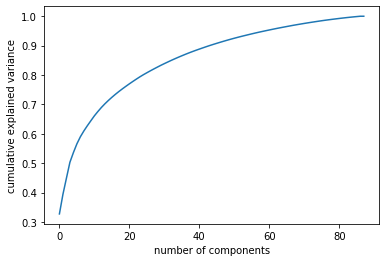

In [161]:
plt.plot(np.cumsum(pipeline_pca.named_steps['pca'].explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [162]:
kbest_pca = SelectKBest(k="all")
kbest_pca.fit(pca_keep, training_y)

SelectKBest(k='all', score_func=<function f_classif at 0x7f8f05d4edd0>)

<BarContainer object of 87 artists>

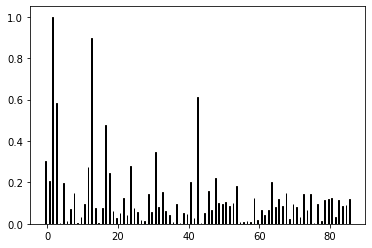

In [163]:
# indices
X_indices = np.arange(pca_keep.shape[-1] )
scores = -np.log10(kbest_pca.pvalues_)
scores /= scores.max()
plt.bar(X_indices - .45, scores, width=.2,
        label=r'Univariate score ($-Log(p_{value})$)', color='darkorange',
        edgecolor='black')

In [165]:
# get the two best components
kbest_pca.k = 2
best_components = kbest_pca.fit_transform(pca_keep, training_y)

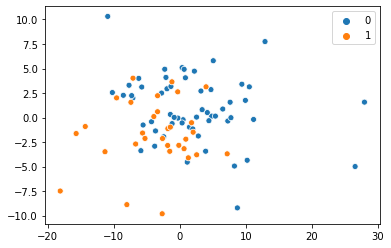

In [171]:
sns.scatterplot(x=best_components[:,0], y=best_components[:,1], hue=training_y)

In [178]:
indices = kbest_pca.get_support(indices=True)

In [246]:
loadings = pipeline_pca.named_steps['pca'].components_[indices,:]

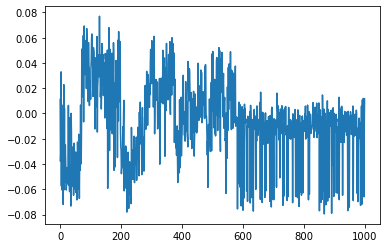

In [279]:
sns.lineplot(x=np.arange(loadings.shape[1]), y=loadings[0,:])

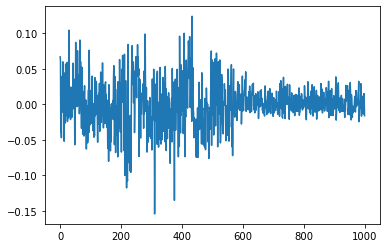

In [280]:
sns.lineplot(x=np.arange(loadings.shape[1]), y=loadings[1,:])

In [249]:
dset_idxs = pipeline_pca.named_steps['kbest'].get_support(indices=True)
columns = training_X.columns[dset_idxs]

In [281]:
# grab top 10 features loaded
comp0_top = np.argpartition(np.abs(loadings[0,:]), -15)[-10:]
# organize the features
comp0_top = comp0_top[np.argsort(np.abs(loadings[0,:])[comp0_top])]

In [282]:
# grab top 10 features loaded
comp1_top = np.argpartition(np.abs(loadings[1,:]), -15)[-10:]
# organize the features
comp1_top = comp1_top[np.argsort(np.abs(loadings[1,:])[comp1_top])]

In [283]:
columns[comp0_top]

Index(['allvol_wm_rh_supramarginal', '31p_r_wm_frontpole_ph',
       '31p_crbl_verm_viii_x_ph', 'alff_ctxristhcing_m',
       '31p_l_rosmidfront_ph', '31p_l_wm_crbl_ph', '31p_l_wm_caudmfg_ph',
       't1r_ctxrcdlantcing_m', '31p_r_opifg_ph', '31p_l_ofug_ph'],
      dtype='object')

In [284]:
columns[comp1_top]

Index(['dti_r_sup_fofas_fa', 'alff_ctxlinfparie_m', 'dti_l_ant_corrad_km',
       'alff_ctxlrostmidfrnt_m', 'allvol_wm_rh_entorhinal', 'alff_lsupfront_m',
       'alff_ctxlprecuneus_m', 'dti_r_cing_gyrus_kax', 'dti_r_sup_fofas_rd',
       'dti_r_sup_fofas_md'],
      dtype='object')

### MISC

In [390]:
prob1 = pipeline1.predict_proba(testing_X) 
prob2 = pipeline2.predict_proba(testing_X) 
prob3 = pipeline3.predict_proba(testing_X)

/home/jdkent/.conda/envs/comfy_pants/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
